# Plot results of training

In [46]:
import argparse
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from time import time, strftime, gmtime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from LstmNet import *
from train_model import *

In [47]:
# Hyper parameters
dataset_path = 'data/stocks.csv'
n_stocks = 26
batch_size = 8
hidden_dim = 128
num_layers = 3

In [50]:
# Import the dataset
df = pd.read_csv(dataset_path)

# Converting into a numpy array
dataset = df.to_numpy()

# Normalizing data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(df)

# Separating the train and test sets
train_dataset, _ = train_test_split(
    scaled_dataset,
    test_size=0.15,
    shuffle=False
)

# Get training and test size
train_size, input_dim = train_dataset.shape

In [56]:
# Load a model

model = LSTMNet(input_dim,
	hidden_size = hidden_dim,
	num_layers = num_layers,
	out_size = input_dim)

model_path = 'results/2026-01-11_23-54-19/model.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to('cpu')
model.eval()

LSTMNet(
  (lstm): LSTM(156, 128, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=156, bias=True)
)

In [57]:
input_dim

156

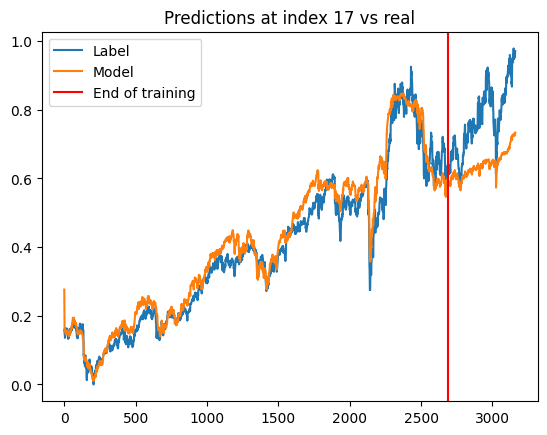

In [59]:
# Semi supervised auto-regression
idx = 17
assert(idx < input_dim)

outputs = []
labels = []

for k in range(0, len(scaled_dataset), batch_size):
    # Put the data on the appropriate device
    if k == 0:
        hn = torch.zeros(model.num_layers, model.hidden_size)
        cn = torch.zeros(model.num_layers, model.hidden_size)
        continue
    inp = torch.from_numpy(scaled_dataset[k-batch_size:k]).to(torch.float32)
    label = torch.from_numpy(scaled_dataset[k - batch_size + 1 : k + 1]).to(torch.float32)
    
    # Computation of the output
    output, (hn, cn) = model(inp, (hn, cn))

    # Saving results
    outputs.extend(output[:, idx].tolist())
    labels.extend(label[:, idx].tolist())


#outputs = scaler.inverse_transform([[0, 0, 0, i, 0, 0] for i in outputs])
#labels = scaler.inverse_transform([[0, 0, 0, i, 0, 0] for i in labels])
plt.plot([labels[i] for i in range(len(labels))], label = 'Label')
plt.plot([outputs[i] for i in range(len(outputs))], label = 'Model')
plt.title(f'Predictions at index {idx} vs real')
plt.axvline(x=train_size, color = 'r', label = 'End of training')
plt.legend()
plt.show()